In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.spatial.distance import cdist

from sklearn.metrics import pairwise_distances_argmin_min
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier

In [2]:
ond_df = pd.read_csv(("C:/Users/79217/OneDrive - Scandinavian Airlines/Documents/COM Data Science/RM/Sponsoring OnDs/Test/OnD_spons_data.csv.gz"),compression='gzip', low_memory=True, sep=",", header = 'infer')
puc_df = pd.read_csv(("C:/Users/79217/OneDrive - Scandinavian Airlines/Documents/COM Data Science/RM/Sponsoring OnDs/Test/OnD_PUC.csv"), low_memory=True, sep=",", header = 'infer')
rev_df = pd.read_csv(("C:/Users/79217/OneDrive - Scandinavian Airlines/Documents/COM Data Science/RM/Sponsoring OnDs/Test/Spons_OnD_REV.csv"), low_memory=True, sep=",", header = 'infer')
onds_exclude_df = pd.read_csv(("C:/Users/79217/OneDrive - Scandinavian Airlines/Documents/COM Data Science/RM/Sponsoring OnDs/Test/new_pot_alteaondspons_exclude.csv"), low_memory=True, sep=",", header = 'infer')
altea_ond_spons_df = pd.read_csv(("C:/Users/79217/OneDrive - Scandinavian Airlines/Documents/COM Data Science/RM/Sponsoring OnDs/Test/alteaondspons_postcutover.csv"), low_memory=True, sep=",", header = 'infer')
eligible_spons_df = pd.read_csv(("C:/Users/79217/OneDrive - Scandinavian Airlines/Documents/COM Data Science/RM/Sponsoring OnDs/Test/alteaondspons_eligible_postcutover.csv"), low_memory=True, sep=",", header = 'infer')
airport_df = pd.read_parquet("C:/Users/79217/OneDrive - Scandinavian Airlines/Documents/COM Data Science/RM/Sponsoring OnDs/Test/airportCoordinates.parquet", engine='pyarrow')

#ondspons_gcdiff_df = spark.read.format('csv').options(header='true', inferSchema='true').load("dbfs:/mnt/sasweucomexa/projects/OnD Sponsoring/in/training/Spons_OnDs_SysGCdiff_Excl09o10.csv").toPandas()


In [3]:
#altea_ond_spons_df.sample(3)           #df containing all OnDs and their respective sponsors
#eligible_spons_df.sample(3)            #df containing all OnDs and their respective sponsors that are eligible for sponsoring by SK
#onds_exclude_df.sample(3)              #df containing all OnDs that are excluded from sponsoring project
ond_df.sample(3)                        #df containing main features for all onds
#puc_df.sample(3)                       #df containing puc percentiles for all onds
#rev_df.sample(3)                       #df containing revenue ticket percentiles for all onds

,Origin,Destination,Jan_PAX,Feb_PAX,Mar_PAX,Apr_PAX,May_PAX,Jun_PAX,Jul_PAX,Aug_PAX,...,DOW3_PAX,DOW4_PAX,DOW5_PAX,DOW6_PAX,DOW7_PAX,Total_PAX,Total_C,Total_CMP,Total_Rev,Avg_Dbd
2257,FCO,LED,79,0,2,26,33,30,7,15,...,5,28,20,84,45,224,0,0,48030.95,84.25
2413,LPI,TLL,1,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,1,0.00,32.00
4392,SPU,PVG,0,0,0,2,8,5,8,8,...,13,0,2,24,1,48,0,6,37782.13,45.00


In [4]:
eligible_spons_df = eligible_spons_df.drop(['Change'], axis = 1)
eligible_spons_df.sample(3)

,OnDSponsor
141,CPH-GOT
261,LYR-TOS
392,UME-ARN


In [5]:
print(len(eligible_spons_df))
print(len(altea_ond_spons_df))

407
4392


In [6]:
# Add cordinates for origin and destination airport
ond_df = ond_df.merge(airport_df[['STN_CD','LAT','LON']], left_on = 'Origin', right_on= 'STN_CD')
ond_df = ond_df.drop(['STN_CD'], axis = 1 )
ond_df = ond_df.rename(columns = {"LAT": "origin_lat", "LON": "origin_long"})
ond_df = ond_df.merge(airport_df[['STN_CD','LAT','LON']], left_on = 'Destination', right_on= 'STN_CD')
ond_df = ond_df.drop(['STN_CD'], axis = 1)
ond_df = ond_df.rename(columns = {"LAT":"destination_lat", "LON":"destination_long"})
ond_df['origin_lat'] = ond_df['origin_lat'].astype(float)
ond_df['origin_long'] = ond_df['origin_long'].astype(float)
ond_df['destination_lat'] = ond_df['destination_lat'].astype(float)
ond_df['destination_long'] = ond_df['destination_long'].astype(float)

In [7]:
ond_df.sample(3)

,Origin,Destination,Jan_PAX,Feb_PAX,Mar_PAX,Apr_PAX,May_PAX,Jun_PAX,Jul_PAX,Aug_PAX,...,DOW7_PAX,Total_PAX,Total_C,Total_CMP,Total_Rev,Avg_Dbd,origin_lat,origin_long,destination_lat,destination_long
621,EWR,KSU,9,21,35,29,57,15,35,39,...,53,370,33,17,569764.33,140.19,40.695833,-74.171666,63.114722,7.844444
10252,LHR,PMI,0,0,4,2,33,1,14,15,...,10,76,12,6,71519.38,54.17,51.471388,-0.452778,39.551667,2.738888
11564,ATH,FAE,1,0,0,0,2,0,10,0,...,0,15,12,0,26894.06,122.60,37.936388,23.944444,62.066666,-7.266666


In [8]:
#Remove OnDs to be predicted , where we have no historical data (started flying post-pandemic, where as model is trained on pre-pandemic data)
altea_ond_spons_df = altea_ond_spons_df.rename(columns={'OnDSponsor':'AlteaOnDSponsor'})
altea_ond_spons_df = altea_ond_spons_df[((altea_ond_spons_df['AlteaOnDSponsor'] !='BGO-BDU') & (altea_ond_spons_df['AlteaOnDSponsor'] !='TRD-BDU') & (altea_ond_spons_df['AlteaOnDSponsor'] !='OSL-BDU') & (altea_ond_spons_df['AlteaOnDSponsor'] !='BDU-TRD') & (altea_ond_spons_df['AlteaOnDSponsor'] != 'ARN-BER') & (altea_ond_spons_df['AlteaOnDSponsor'] != 'CPH-BER') & (altea_ond_spons_df['AlteaOnDSponsor'] != 'BDU-OSL') & (altea_ond_spons_df['AlteaOnDSponsor'] != 'BDU-BGO'))]
print(len(altea_ond_spons_df.index))

4356


In [9]:
#create first booking behavioural features

ond_df['jan_paxratio'] = ond_df['Jan_PAX'] / ond_df['Total_PAX']
ond_df['feb_paxratio'] = ond_df['Feb_PAX'] / ond_df['Total_PAX']
ond_df['mar_paxratio'] = ond_df['Mar_PAX'] / ond_df['Total_PAX']
ond_df['apr_paxratio'] = ond_df['Apr_PAX'] / ond_df['Total_PAX']
ond_df['may_paxratio'] = ond_df['May_PAX'] / ond_df['Total_PAX']
ond_df['jun_paxratio'] = ond_df['Jun_PAX'] / ond_df['Total_PAX']
ond_df['jul_paxratio'] = ond_df['Jul_PAX'] / ond_df['Total_PAX']
ond_df['aug_paxratio'] = ond_df['Aug_PAX'] / ond_df['Total_PAX']
ond_df['sep_paxratio'] = ond_df['Sep_PAX'] / ond_df['Total_PAX']
ond_df['oct_paxratio'] = ond_df['Oct_PAX'] / ond_df['Total_PAX']
ond_df['nov_paxratio'] = ond_df['Nov_PAX'] / ond_df['Total_PAX']
ond_df['dec_paxratio'] = ond_df['Dec_PAX'] / ond_df['Total_PAX']
ond_df['dow1_ratio'] = ond_df['DOW1_PAX'] / ond_df['Total_PAX']
ond_df['dow2_ratio'] = ond_df['DOW2_PAX'] / ond_df['Total_PAX']
ond_df['dow3_ratio'] = ond_df['DOW3_PAX'] / ond_df['Total_PAX']
ond_df['dow4_ratio'] = ond_df['DOW4_PAX'] / ond_df['Total_PAX']
ond_df['dow5_ratio'] = ond_df['DOW5_PAX'] / ond_df['Total_PAX']
ond_df['dow6_ratio'] = ond_df['DOW6_PAX'] / ond_df['Total_PAX']
ond_df['dow7_ratio'] = ond_df['DOW7_PAX'] / ond_df['Total_PAX']
ond_df['Ave_Rev'] = ond_df['Total_Rev'] / ond_df['Total_PAX']
ond_df['C_ratio'] = ond_df['Total_C'] / ond_df['Total_PAX']
ond_df['CMP_ratio'] = ond_df['Total_CMP'] / ond_df['Total_PAX']

In [10]:
ond_df.sample(3)

,Origin,Destination,Jan_PAX,Feb_PAX,Mar_PAX,Apr_PAX,May_PAX,Jun_PAX,Jul_PAX,Aug_PAX,...,dow1_ratio,dow2_ratio,dow3_ratio,dow4_ratio,dow5_ratio,dow6_ratio,dow7_ratio,Ave_Rev,C_ratio,CMP_ratio
10959,MLA,MOL,0,0,0,2,0,0,6,3,...,0.181818,0.000000,0.000000,0.181818,0.000000,0.181818,0.454545,1023.511818,0.000000,0.000000
7414,KRN,RNB,88,109,151,165,111,117,237,189,...,0.193050,0.088160,0.108108,0.162806,0.179537,0.000000,0.268340,750.827284,0.074646,0.157658
2550,PMI,IAD,6,1,12,6,5,10,22,10,...,0.204545,0.159091,0.079545,0.045455,0.090909,0.102273,0.318182,951.978409,0.011364,0.000000


In [11]:
#Create key based on unique value Origin and Destination (OnD)
ond_df['ond_key'] = ond_df['Origin'].str.strip() +'-'+ ond_df['Destination'].str.strip()
puc_df['ond_key'] = puc_df['Origin'].str.strip() +'-'+ puc_df['Destination'].str.strip()
rev_df['ond_key'] = rev_df['Origin'].str.strip() +'-'+ rev_df['Destination'].str.strip()

In [12]:
puc_df.sample(3)

,Origin,Destination,Bkg_Dbdcount,Bkg_Dbdmean,Bkg_Dbdstd,Bkg_Dbdmin,Bkg_Dbd10%,Bkg_Dbd20%,Bkg_Dbd30%,Bkg_Dbd40%,Bkg_Dbd50%,Bkg_Dbd60%,Bkg_Dbd70%,Bkg_Dbd80%,Bkg_Dbd90%,Bkg_Dbdmax,ond_key
3421,FAE,DUB,26.0,77.730769,66.658267,1.0,1.0,3.0,29.5,32.0,62.0,108.0,129.0,152.0,167.0,178.0,FAE-DUB
1881,BLQ,BOS,67.0,66.835821,53.596867,3.0,17.6,23.0,28.8,38.0,43.0,62.4,84.4,109.2,144.6,215.0,BLQ-BOS
71,AAL,MXP,2597.0,60.550635,70.581981,0.0,5.6,9.0,16.0,24.0,33.0,45.0,65.0,98.0,160.0,343.0,AAL-MXP


In [13]:
#Create list which will be used to remove OnDs, specifically Long-Haul OnD's in this case. Due to the project only focusing on Short Haul.
ond_list = ['BOS','MIA','EWR','IAD','PVG','HND','ORD','LAX','SFO','NRT','HKG','PEK']
ond_exclude_df = pd.DataFrame(ond_list,columns =['OnD'])
#ond_exclude_df['OnD'] = ond_exclude_df['OnD'].str.strip()
ond_exclude_df.head(3)

,OnD
0,BOS
1,MIA
2,EWR


In [14]:
#Merge df's into one main df and remove Long Haul OnDs
ond_puc_df = ond_df.merge(puc_df, left_on=['ond_key'], right_on=['ond_key'], how = 'left')
ond_puc_df = ond_puc_df.drop(['Origin_y'], axis = 1)
ond_puc_df = ond_puc_df.drop(['Destination_y'], axis = 1)
ond_puc_df = ond_puc_df.rename(columns ={"Origin_x":"Origin", "Destination_x":"Destination"})
ond_puc_df['Exclude_Origin'] = ~ond_puc_df['Origin'].str.strip().isin(ond_exclude_df['OnD'].str.strip())
ond_puc_df['Exclude_Destination'] = ~ond_puc_df['Destination'].str.strip().isin(ond_exclude_df['OnD'].str.strip())
ond_puc_df = ond_puc_df.merge(rev_df, left_on=['ond_key'], right_on=['ond_key'], how = 'left')
ond_puc_df = ond_puc_df.drop(['Origin_y'], axis = 1)
ond_puc_df = ond_puc_df.drop(['Destination_y'], axis = 1)
ond_puc_df = ond_puc_df.rename(columns = {"Origin_x" : "Origin", "Destination_x": "Destination"})
ond_puc_df = ond_puc_df.reset_index()


In [15]:
#Merge with Amadeus provided list of OnD and their donor sponsor (AlteaOnDSponsor)
ond_puc_df = ond_puc_df.merge(altea_ond_spons_df, left_on=['ond_key'], right_on=['OnD'], how = 'left')
ond_puc_df = ond_puc_df.drop(columns = 'OnD')

In [16]:
ond_puc_df.sample(3)

,index,Origin,Destination,Jan_PAX,Feb_PAX,Mar_PAX,Apr_PAX,May_PAX,Jun_PAX,Jul_PAX,...,FLOWN_REVmean,FLOWN_REVstd,FLOWN_REVmin,FLOWN_REV10%,FLOWN_REV30%,FLOWN_REV50%,FLOWN_REV70%,FLOWN_REV90%,FLOWN_REVmax,AlteaOnDSponsor
1696,1696,SFT,SFT,6,5,5,10,9,12,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6384,6384,GOT,KRS,11,4,1,2,1,2,4,...,1017.774750,433.606637,191.72,580.799,821.35,957.270,1126.932,1446.391,4911.70,GOT-SVG
4777,4777,BLL,MXP,60,37,45,55,44,35,63,...,1981.121951,1147.131193,213.40,544.010,1291.38,1964.355,2509.254,3373.775,6148.91,SVG-MXP


In [17]:
ond_df_train = ond_puc_df
ond_df_predict = ond_puc_df

In [18]:
#Seperate dfs into OnDs in need of a sponsor to be predicted with a donor sponsor (train)
ond_df_train['Flag'] = ond_df_train.ond_key.isin(eligible_spons_df.OnDSponsor)
ond_df_train = ond_df_train[ond_df_train['Flag'] == True]
ond_df_predict['Flag'] = ond_df_predict.ond_key.isin(altea_ond_spons_df.OnD)
ond_df_predict = ond_df_predict[ond_df_predict['Flag'] == True]
print(len(ond_df_train.index))
print(len(ond_df_predict.index))

407
4166


In [19]:
ond_df_train.head(3)


,index,Origin,Destination,Jan_PAX,Feb_PAX,Mar_PAX,Apr_PAX,May_PAX,Jun_PAX,Jul_PAX,...,FLOWN_REVstd,FLOWN_REVmin,FLOWN_REV10%,FLOWN_REV30%,FLOWN_REV50%,FLOWN_REV70%,FLOWN_REV90%,FLOWN_REVmax,AlteaOnDSponsor,Flag
129,129,MMX,OSD,1148,1965,1891,1336,1211,1070,450,...,773.088749,0.0,461.00,813.00,1177.0,1455.81,2353.92,5233.97,NaN,True
149,149,GOT,OSD,2580,3110,3520,2726,2950,2294,1176,...,723.101928,0.0,563.00,892.95,1044.0,1422.02,2188.02,8119.98,NaN,True
153,153,ARN,OSD,24223,29297,31952,25827,25906,20296,9535,...,574.782744,0.0,331.72,602.00,872.9,1195.95,1826.00,22415.62,NaN,True


In [20]:
#Stochastic approach, remove OnDs with little or too little data to predict
print(len(altea_ond_spons_df))
print(len(ond_df_predict.index))
ond_df_predict = ond_df_predict[ond_df_predict['Total_PAX'] > 300].dropna().reset_index(drop=True)
print(len(ond_df_predict.index))
print(len(ond_df_train))


4356
4166
1925
407


In [21]:
ond_df_train['Sponsor'] = ond_df_train.ond_key.isin(eligible_spons_df.OnDSponsor)
ond_sponsor_df = ond_df_train[ond_df_train['Sponsor'] == True].reset_index(drop=True)
#ond_sponsor_df['AlteaOnDSponsor'] = ond_sponsor_df['AlteaOnDSponsor'].replace(np.nan, 'None') 
ond_sponsor_df = ond_sponsor_df.replace(np.nan, 0)
ond_sponsor_df.head()

C:\Users\79217\AppData\Local\Temp\ipykernel_33596\2555994197.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ond_df_train['Sponsor'] = ond_df_train.ond_key.isin(eligible_spons_df.OnDSponsor)


,index,Origin,Destination,Jan_PAX,Feb_PAX,Mar_PAX,Apr_PAX,May_PAX,Jun_PAX,Jul_PAX,...,FLOWN_REVmin,FLOWN_REV10%,FLOWN_REV30%,FLOWN_REV50%,FLOWN_REV70%,FLOWN_REV90%,FLOWN_REVmax,AlteaOnDSponsor,Flag,Sponsor
0,129,MMX,OSD,1148,1965,1891,1336,1211,1070,450,...,0.0,461.000,813.00,1177.00,1455.810,2353.920,5233.97,0,True,True
1,149,GOT,OSD,2580,3110,3520,2726,2950,2294,1176,...,0.0,563.000,892.95,1044.00,1422.020,2188.020,8119.98,0,True,True
2,153,ARN,OSD,24223,29297,31952,25827,25906,20296,9535,...,0.0,331.720,602.00,872.90,1195.950,1826.000,22415.62,0,True,True
3,179,AGH,OSD,420,720,554,493,510,422,165,...,0.0,565.339,853.00,1126.55,1433.825,2350.622,5351.98,0,True,True
4,192,LLA,OSD,834,984,1068,767,945,625,295,...,159.0,678.000,1454.00,2278.06,2961.450,4056.000,6371.97,0,True,True


In [22]:
altea_ond_sponsor_df = altea_ond_spons_df.drop(columns=['OnD'])

In [23]:
ond_df_train2 = ond_puc_df
ond_df_train2['Sponsor'] = ond_df_train2.ond_key.isin(altea_ond_sponsor_df.AlteaOnDSponsor)
altea_ond_sponsor_df = ond_df_train2[ond_df_train2['Sponsor'] == True].reset_index(drop=True)
print(len(ond_df_train.index))
print(len(ond_df_train2))

407
12375


In [24]:
#Main df is for OnDs that SK are able to sponsor vs df2 where all OnDs are accounted for, being sponsored by Amadeus.
X_train = ond_sponsor_df.drop(columns=['index','Origin','Destination','Total_CMP','Total_Rev','Total_PAX','Total_C','Jan_PAX','Feb_PAX','Mar_PAX','Apr_PAX','May_PAX','Jun_PAX','Jul_PAX','Aug_PAX','Sep_PAX','Oct_PAX','Nov_PAX','Dec_PAX','Jan_CMP','Feb_CMP','Mar_CMP','Apr_CMP','May_CMP','Jun_CMP','Jul_CMP','Aug_CMP','Sep_CMP','Oct_CMP','Nov_CMP','Dec_CMP','DOW1_PAX','DOW2_PAX','DOW3_PAX','DOW4_PAX','DOW5_PAX','DOW6_PAX','DOW7_PAX','Avg_Dbd','Bkg_Dbdcount','Bkg_Dbdmin','Bkg_Dbdmax','Bkg_Dbdstd','Bkg_Dbdmean','ond_key','Sponsor','Exclude_Origin','Exclude_Destination','AlteaOnDSponsor','FLOWN_REVcount','FLOWN_REVmin','FLOWN_REVmax','FLOWN_REVmean','Ave_Rev','Flag'])
X_train2 = altea_ond_sponsor_df.drop(columns=['index','Origin','Destination','Total_CMP','Total_Rev','Total_PAX','Total_C','Jan_PAX','Feb_PAX','Mar_PAX','Apr_PAX','May_PAX','Jun_PAX','Jul_PAX','Aug_PAX','Sep_PAX','Oct_PAX','Nov_PAX','Dec_PAX','Jan_CMP','Feb_CMP','Mar_CMP','Apr_CMP','May_CMP','Jun_CMP','Jul_CMP','Aug_CMP','Sep_CMP','Oct_CMP','Nov_CMP','Dec_CMP','DOW1_PAX','DOW2_PAX','DOW3_PAX','DOW4_PAX','DOW5_PAX','DOW6_PAX','DOW7_PAX','Avg_Dbd','Bkg_Dbdcount','Bkg_Dbdmin','Bkg_Dbdmax','Bkg_Dbdstd','Bkg_Dbdmean','ond_key','Sponsor','Exclude_Origin','Exclude_Destination','AlteaOnDSponsor','FLOWN_REVcount','FLOWN_REVmin','FLOWN_REVmax','FLOWN_REVmean','Ave_Rev','Flag'])

In [25]:
X_train.columns

Index(['origin_lat', 'origin_long', 'destination_lat', 'destination_long',
       'jan_paxratio', 'feb_paxratio', 'mar_paxratio', 'apr_paxratio',
       'may_paxratio', 'jun_paxratio', 'jul_paxratio', 'aug_paxratio',
       'sep_paxratio', 'oct_paxratio', 'nov_paxratio', 'dec_paxratio',
       'dow1_ratio', 'dow2_ratio', 'dow3_ratio', 'dow4_ratio', 'dow5_ratio',
       'dow6_ratio', 'dow7_ratio', 'C_ratio', 'CMP_ratio', 'Bkg_Dbd10%',
       'Bkg_Dbd20%', 'Bkg_Dbd30%', 'Bkg_Dbd40%', 'Bkg_Dbd50%', 'Bkg_Dbd60%',
       'Bkg_Dbd70%', 'Bkg_Dbd80%', 'Bkg_Dbd90%', 'FLOWN_REVstd',
       'FLOWN_REV10%', 'FLOWN_REV30%', 'FLOWN_REV50%', 'FLOWN_REV70%',
       'FLOWN_REV90%'],
      dtype='object')

In [26]:
X_train2.columns

Index(['origin_lat', 'origin_long', 'destination_lat', 'destination_long',
       'jan_paxratio', 'feb_paxratio', 'mar_paxratio', 'apr_paxratio',
       'may_paxratio', 'jun_paxratio', 'jul_paxratio', 'aug_paxratio',
       'sep_paxratio', 'oct_paxratio', 'nov_paxratio', 'dec_paxratio',
       'dow1_ratio', 'dow2_ratio', 'dow3_ratio', 'dow4_ratio', 'dow5_ratio',
       'dow6_ratio', 'dow7_ratio', 'C_ratio', 'CMP_ratio', 'Bkg_Dbd10%',
       'Bkg_Dbd20%', 'Bkg_Dbd30%', 'Bkg_Dbd40%', 'Bkg_Dbd50%', 'Bkg_Dbd60%',
       'Bkg_Dbd70%', 'Bkg_Dbd80%', 'Bkg_Dbd90%', 'FLOWN_REVstd',
       'FLOWN_REV10%', 'FLOWN_REV30%', 'FLOWN_REV50%', 'FLOWN_REV70%',
       'FLOWN_REV90%'],
      dtype='object')

In [27]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_train2_scaled = scaler.fit_transform(X_train2)

In [28]:
X_predict = ond_df_predict.drop(columns=['index','Origin','Destination','Total_CMP','Total_Rev','Total_PAX','Total_C','Jan_PAX','Feb_PAX','Mar_PAX','Apr_PAX','May_PAX','Jun_PAX','Jul_PAX','Aug_PAX','Sep_PAX','Oct_PAX','Nov_PAX','Dec_PAX','Jan_CMP','Feb_CMP','Mar_CMP','Apr_CMP','May_CMP','Jun_CMP','Jul_CMP','Aug_CMP','Sep_CMP','Oct_CMP','Nov_CMP','Dec_CMP','DOW1_PAX','DOW2_PAX','DOW3_PAX','DOW4_PAX','DOW5_PAX','DOW6_PAX','DOW7_PAX','Avg_Dbd','Bkg_Dbdcount','Bkg_Dbdmin','Bkg_Dbdmax','Bkg_Dbdstd','Bkg_Dbdmean','ond_key','Exclude_Origin','Exclude_Destination','AlteaOnDSponsor','FLOWN_REVcount','FLOWN_REVmin','FLOWN_REVmax','FLOWN_REVmean','Ave_Rev','Flag'])
X_predict_scaled = scaler.transform(X_predict)

In [29]:
print(type(X_predict_scaled))
print(type(X_train_scaled))
print(type(X_train2_scaled))

<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>


In [30]:
closest, distance = pairwise_distances_argmin_min(X_predict_scaled, X_train_scaled)
print(len(closest))
closest_sponsor = ond_sponsor_df['ond_key'].iloc[closest].values
print(closest_sponsor)
print(closest)
print(distance)


1925
['GOT-OSD' 'DUS-OSL' 'AGP-ARN' ... 'PMI-ARN' 'BLQ-ARN' 'BLQ-ARN']
[  1 222  32 ...  45  78  78]
[ 2.65748897  3.3863507   6.19303746 ... 12.54037373 14.05221904
 23.89806606]


In [31]:
ond_df_predict['NN_Spons_Distance'] = distance
ond_df_predict['NN_Sponsor'] = ond_sponsor_df['ond_key'].iloc[closest].values
ond_df_predict.head(3)

,index,Origin,Destination,Jan_PAX,Feb_PAX,Mar_PAX,Apr_PAX,May_PAX,Jun_PAX,Jul_PAX,...,FLOWN_REV10%,FLOWN_REV30%,FLOWN_REV50%,FLOWN_REV70%,FLOWN_REV90%,FLOWN_REVmax,AlteaOnDSponsor,Flag,NN_Spons_Distance,NN_Sponsor
0,101,RNB,OSD,207,296,367,224,245,282,105,...,641.146,923.00,1194.975,1636.50,2596.755,4646.10,GOT-OSD,True,2.657489,GOT-OSD
1,102,CDG,OSD,127,140,223,163,171,205,165,...,574.804,1043.80,1479.585,1918.94,2740.981,6834.29,BRU-TRD,True,3.386351,DUS-OSL
2,104,AGP,OSD,51,57,147,143,167,173,142,...,471.815,1148.48,1665.130,2144.12,3087.040,11028.48,AGP-OSL,True,6.193037,AGP-ARN


In [32]:
#Initiates a loop that iterates through each row in ond_df_predict. The loop assigns the index (df_index) and the row itself (row) to the respective variables.

altea_ond_sponsor_distance_list = []
for df_index, row in ond_df_predict.iterrows():
  print(df_index)
  print(row)
  print(row['AlteaOnDSponsor'])

0
index                     101
Origin                  RNB  
Destination             OSD  
Jan_PAX                   207
Feb_PAX                   296
                       ...   
FLOWN_REVmax           4646.1
AlteaOnDSponsor       GOT-OSD
Flag                     True
NN_Spons_Distance    2.657489
NN_Sponsor            GOT-OSD
Name: 0, Length: 96, dtype: object
GOT-OSD
1
index                     102
Origin                  CDG  
Destination             OSD  
Jan_PAX                   127
Feb_PAX                   140
                       ...   
FLOWN_REVmax          6834.29
AlteaOnDSponsor       BRU-TRD
Flag                     True
NN_Spons_Distance    3.386351
NN_Sponsor            DUS-OSL
Name: 1, Length: 96, dtype: object
BRU-TRD
2
index                     104
Origin                  AGP  
Destination             OSD  
Jan_PAX                    51
Feb_PAX                    57
                       ...   
FLOWN_REVmax         11028.48
AlteaOnDSponsor       AGP-OSL
Flag    

index                     554
Origin                  TXL  
Destination             KSU  
Jan_PAX                    87
Feb_PAX                   103
                       ...   
FLOWN_REVmax          5418.85
AlteaOnDSponsor       CPH-AES
Flag                     True
NN_Spons_Distance    4.356237
NN_Sponsor            FRA-OSL
Name: 84, Length: 96, dtype: object
CPH-AES
85
index                     555
Origin                  DUB  
Destination             KSU  
Jan_PAX                    13
Feb_PAX                    21
                       ...   
FLOWN_REVmax          5662.22
AlteaOnDSponsor       DUB-BGO
Flag                     True
NN_Spons_Distance    5.547308
NN_Sponsor            DUB-OSL
Name: 85, Length: 96, dtype: object
DUB-BGO
86
index                     558
Origin                  KKN  
Destination             KSU  
Jan_PAX                    44
Feb_PAX                    41
                       ...   
FLOWN_REVmax           5876.7
AlteaOnDSponsor       KKN-BGO
Flag  

In [33]:
#Produces a list of the index of the row in altea_ond_sponsor_df that matches the AlteaOnDSponsor value in the row of ond_df_predict. The index is then assigned to the variable altea_spons_index. 
#This will result in a list containing the distance between each ond in the predict df and the distance between it and the altea choice of sponsor.

altea_ond_sponsor_distance_list = []
for df_index, row in ond_df_predict.iterrows():
  print(df_index)
  print(row['AlteaOnDSponsor'])
  altea_spons_index = altea_ond_sponsor_df[altea_ond_sponsor_df['ond_key'] == row['AlteaOnDSponsor']].index[0]
  closest, distance = pairwise_distances_argmin_min([X_predict_scaled[df_index]], [X_train2_scaled[altea_spons_index]])
  altea_ond_sponsor_distance_list.append(distance[0])

0
GOT-OSD
1
BRU-TRD
2
AGP-OSL
3
TLL-OSL
4
OSL-OSD
5
FCO-OSL
6
LLA-SDL
7
MMX-OSD
8
TLL-OSL
9
BCN-OSL
10
FRA-TRD
11
MXP-OSL
12
VNO-ARN
13
CPH-OSD
14
RIX-ARN
15
MMX-OSD
16
DUB-GOT
17
FRA-TRD
18
DUS-TRD
19
BHX-OSL
20
FRA-TRD
21
TOS-TRD
22
ARN-OSD
23
LLA-OSD
24
FRA-TRD
25
DUS-TRD
26
ALC-BGO
27
EDI-ARN
28
NCE-ARN
29
DUS-TRD
30
MXP-ARN
31
SVG-TRD
32
CPH-OSD
33
EVE-TRD
34
CPH-EVE
35
CDG-TRD
36
AGP-OSL
37
ARN-TOS
38
CPH-EVE
39
OSD-LLA
40
ARN-EVE
41
ARN-KRN
42
AMS-LLA
43
CPH-EVE
44
CPH-TOS
45
DUB-HEL
46
MUC-HEL
47
LHR-UME
48
RNB-LLA
49
GOT-KRN
50
AMS-LLA
51
ALC-ARN
52
SVG-EVE
53
DUS-TRD
54
MXP-OSL
55
CPH-TOS
56
OSD-LLA
57
AMS-LLA
58
AGP-OSL
59
HAU-TOS
60
AMS-LLA
61
OSL-ALF
62
SPU-OSL
63
OSL-ALF
64
MMX-KRN
65
LHR-TOS
66
TRD-ALF
67
KEF-ARN
68
AMS-LLA
69
LHR-LLA
70
AMS-LLA
71
OSL-ALF
72
ARN-TOS
73
ALC-BGO
74
AMS-LLA
75
AMS-TOS
76
CDG-OSL
77
ALC-BGO
78
GDN-BGO
79
NCE-OSL
80
HEL-TRD
81
FRA-TRD
82
VNO-BGO
83
AAL-TRD
84
CPH-AES
85
DUB-BGO
86
KKN-BGO
87
FRA-TRD
88
KEF-CPH
89
DUS-TRD
90
ARN-OSD
91
LHR-TR

In [34]:
print(altea_ond_sponsor_distance_list)

[2.412665767789561, 3.468697254639186, 5.631665533238937, 5.383779785155144, 4.422793936782763, 6.77791793968892, 6.478286967849861, 4.1339965145688575, 7.42185273672902, 9.44488466433378, 8.151256468343625, 13.458977840452798, 7.574745201098341, 7.276630853426529, 6.471039271298112, 6.85802604207243, 3.9223819454920053, 9.217232796728812, 5.509545976888357, 7.8215826686208105, 5.33050227920391, 4.759680862711636, 9.222882784949078, 7.24624784892213, 9.733909840972835, 7.634147435035861, 10.302057727113096, 6.773982470842047, 8.553048984118291, 5.454757528368629, 9.359788586268737, 5.18827779102674, 5.774925472894087, 4.640015339648023, 6.387251995434037, 9.647278208296635, 8.450343259731955, 9.670962458121295, 10.889669201151825, 4.8125617392101665, 4.011141846455708, 5.422413125071557, 10.258074693993283, 7.674546983327684, 7.528600439937894, 8.440553405772134, 10.853341410248099, 13.935543752920626, 5.460592873572574, 10.481413394977402, 10.370354538857521, 8.078915237669543, 11.055

In [35]:
ond_df_predict['Altea_Spons_Distance'] = altea_ond_sponsor_distance_list
ond_df_predict['Diff_Distance'] = ond_df_predict['Altea_Spons_Distance'] - ond_df_predict['NN_Spons_Distance']
ond_df_predict.sample(3)

,index,Origin,Destination,Jan_PAX,Feb_PAX,Mar_PAX,Apr_PAX,May_PAX,Jun_PAX,Jul_PAX,...,FLOWN_REV50%,FLOWN_REV70%,FLOWN_REV90%,FLOWN_REVmax,AlteaOnDSponsor,Flag,NN_Spons_Distance,NN_Sponsor,Altea_Spons_Distance,Diff_Distance
523,3199,AAR,FRA,46,52,81,98,93,86,13,...,1260.13,1857.404,3421.402,7747.55,GOT-FRA,True,3.590285,CPH-AMS,5.585413,1.995127
1450,7983,AMS,KKN,63,106,84,70,128,106,137,...,1539.81,1888.207,2434.330,6626.57,AMS-UME,True,4.482347,SVG-ALF,6.051999,1.569652
390,2297,FRA,TKU,66,77,158,122,128,112,11,...,1307.07,1771.760,2549.422,9975.46,FRA-HEL,True,4.102279,GOT-SFT,5.808959,1.706680


In [36]:
nn_spons_ond_df = ond_df_predict[ond_df_predict['Diff_Distance'] >= 0.2]
no_spons_ond_df = ond_df_predict[ond_df_predict['Diff_Distance'] < 0.2]
print(len(nn_spons_ond_df.index))
print(len(no_spons_ond_df.index))

1502
423


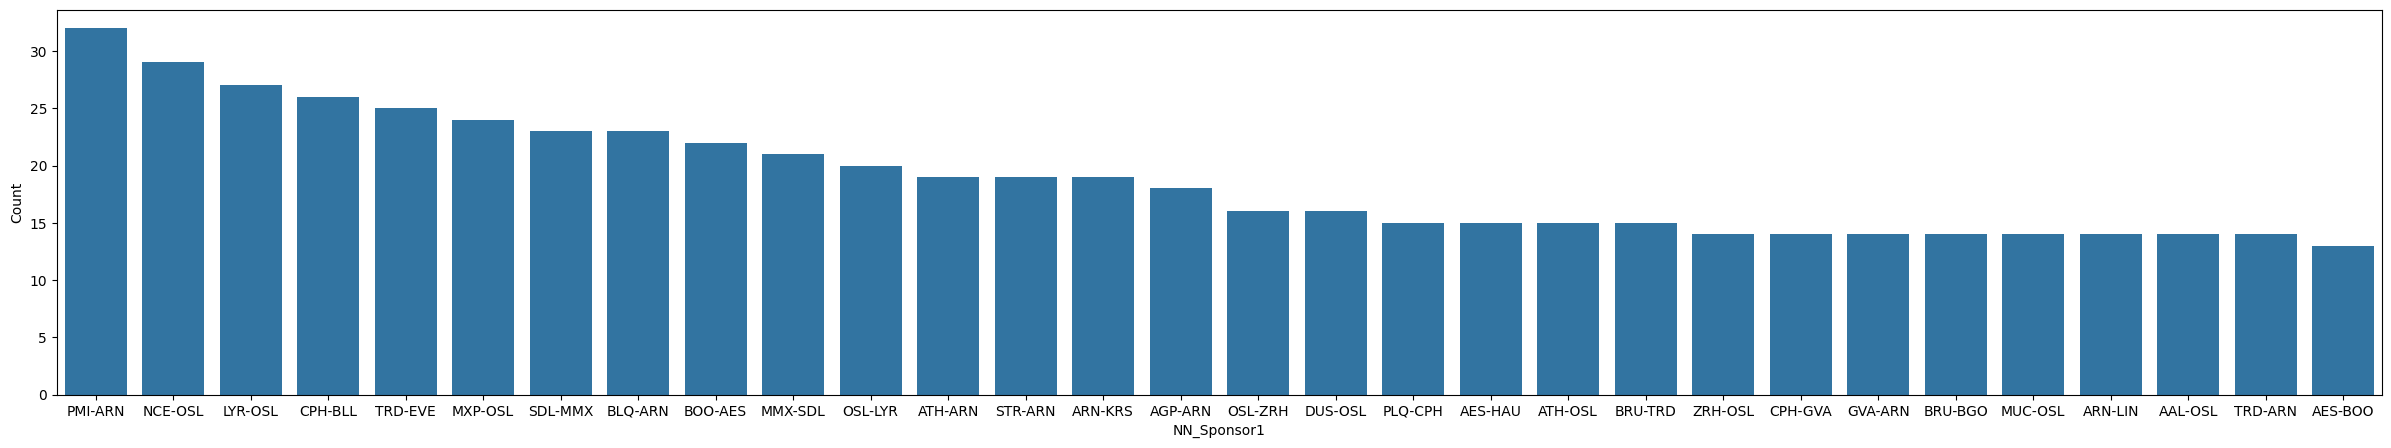

None

In [37]:
NN_sponsor_count = ond_df_predict['NN_Sponsor'].value_counts().reset_index()
NN_sponsor_count.columns = ['NN_Sponsor1', 'Count']
NN_sponsor_count_plot = NN_sponsor_count.head(30)

fig, axes = plt.subplots(1, 1, figsize=(30,5))
sns.barplot(x="NN_Sponsor1", y="Count", data=NN_sponsor_count_plot)
display(plt.show())

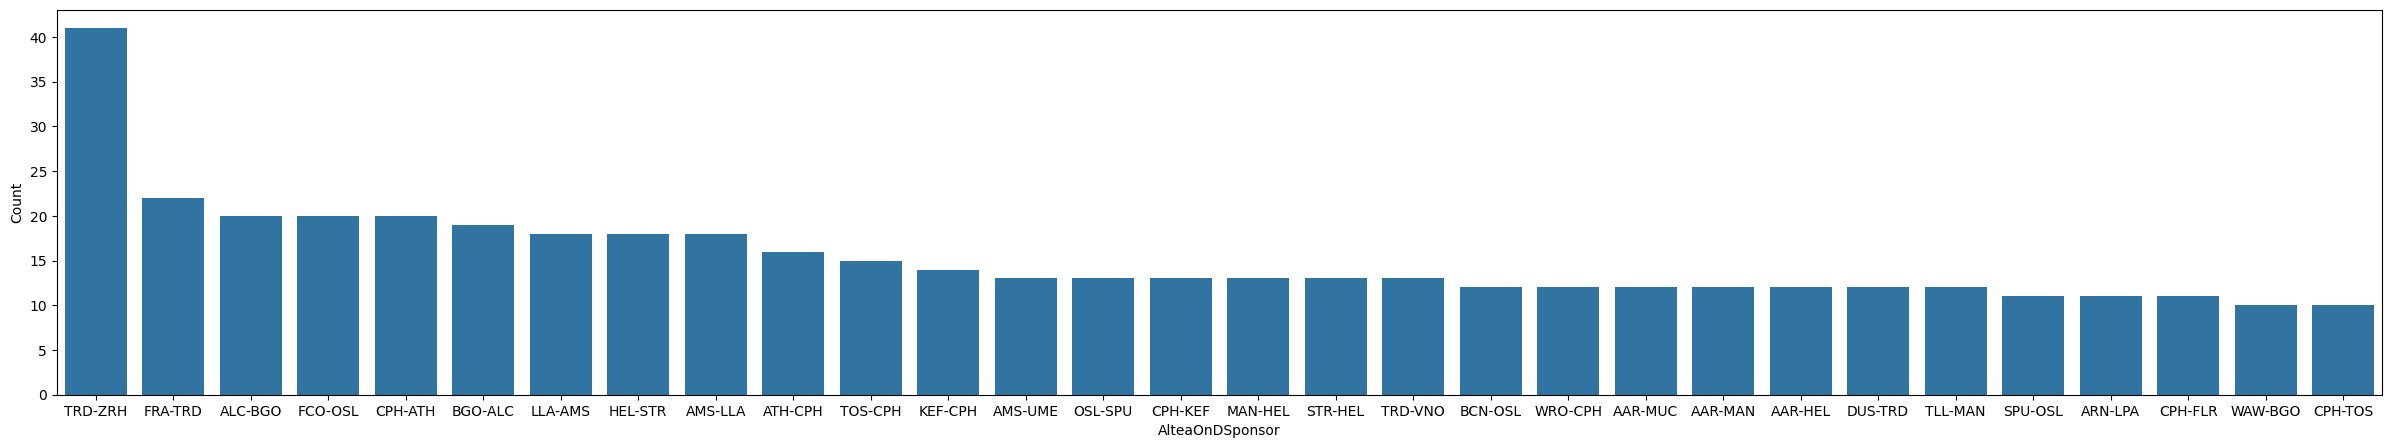

None

In [38]:
altea_sponsor_count = ond_df_predict['AlteaOnDSponsor'].value_counts().reset_index()
altea_sponsor_count.columns = ['AlteaOnDSponsor', 'Count']
altea_sponsor_count_plot = altea_sponsor_count.head(30)

fig, axes = plt.subplots(1, 1, figsize=(30,5))
sns.barplot(x="AlteaOnDSponsor", y="Count", data=altea_sponsor_count_plot)
display(plt.show())

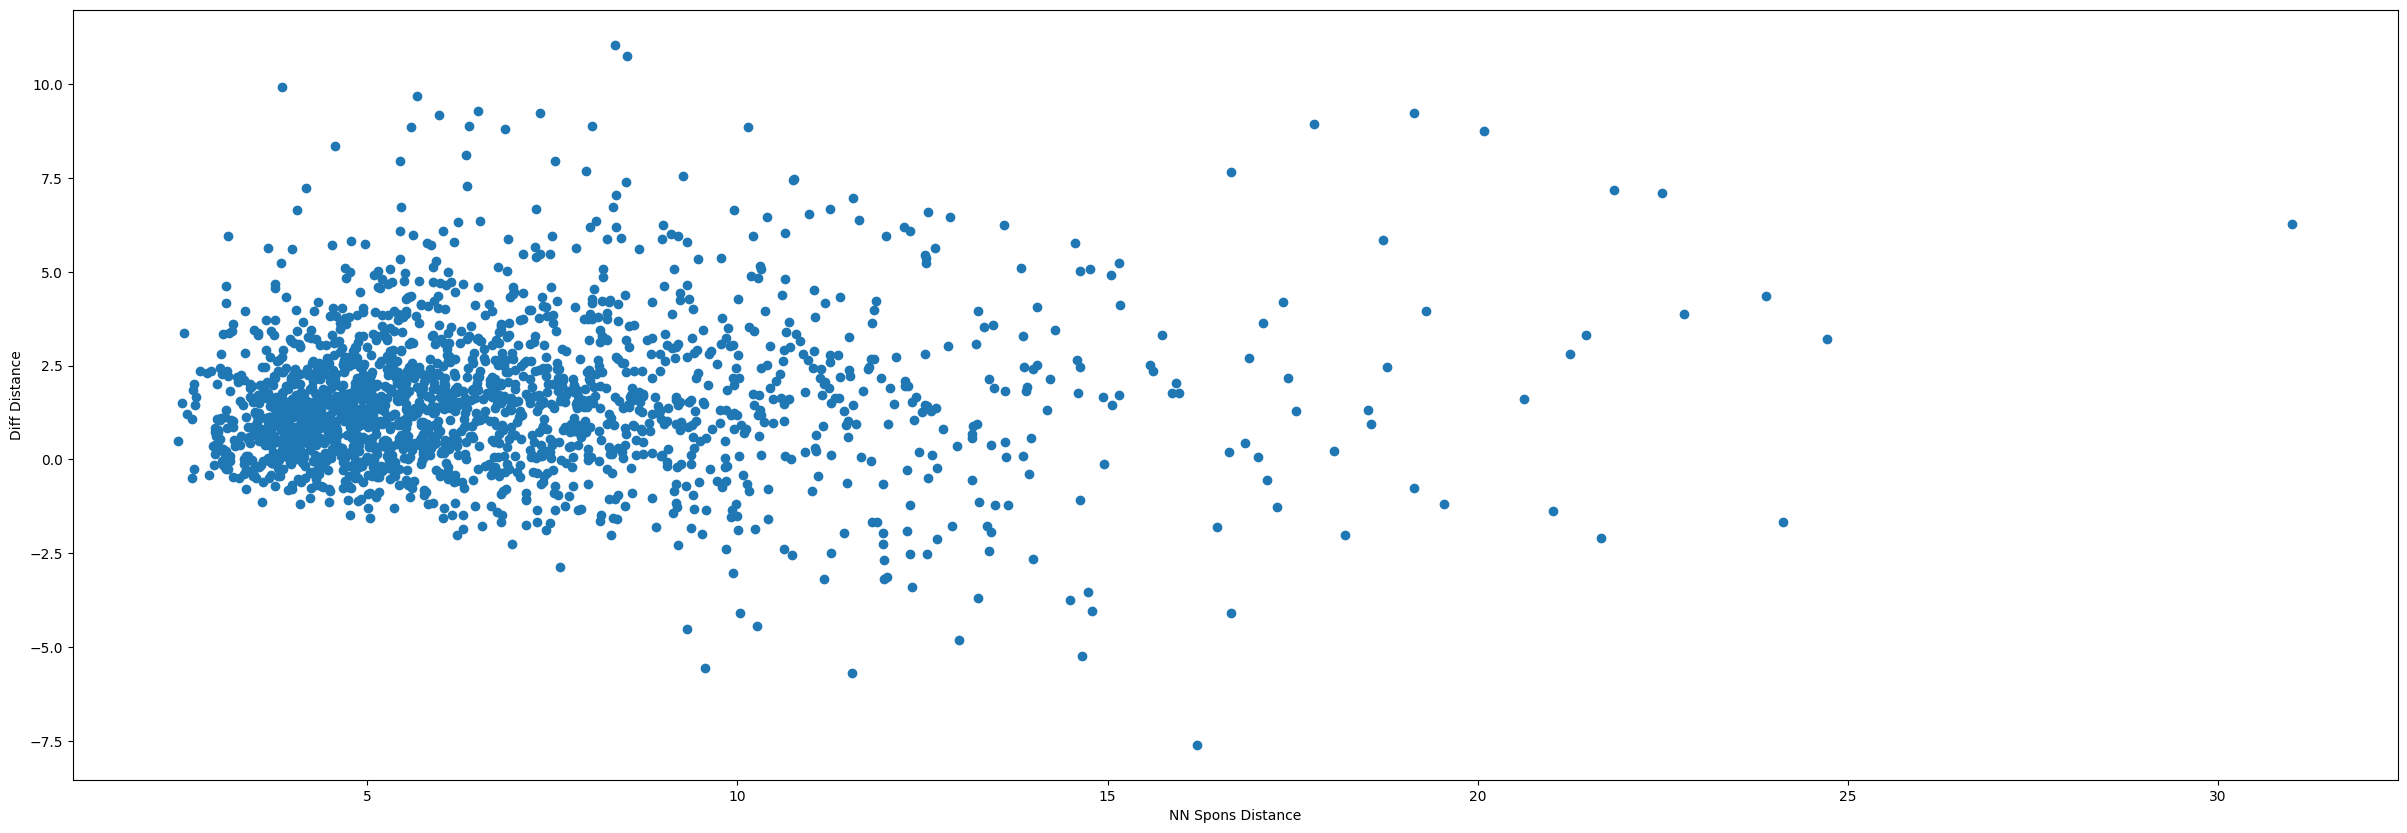

In [39]:
fig, ax = plt.subplots(figsize=(30, 10))
ax.scatter(x = ond_df_predict['NN_Spons_Distance'], y = ond_df_predict['Diff_Distance'])
plt.xlabel('NN Spons Distance')
plt.ylabel('Diff Distance')
plt.show()

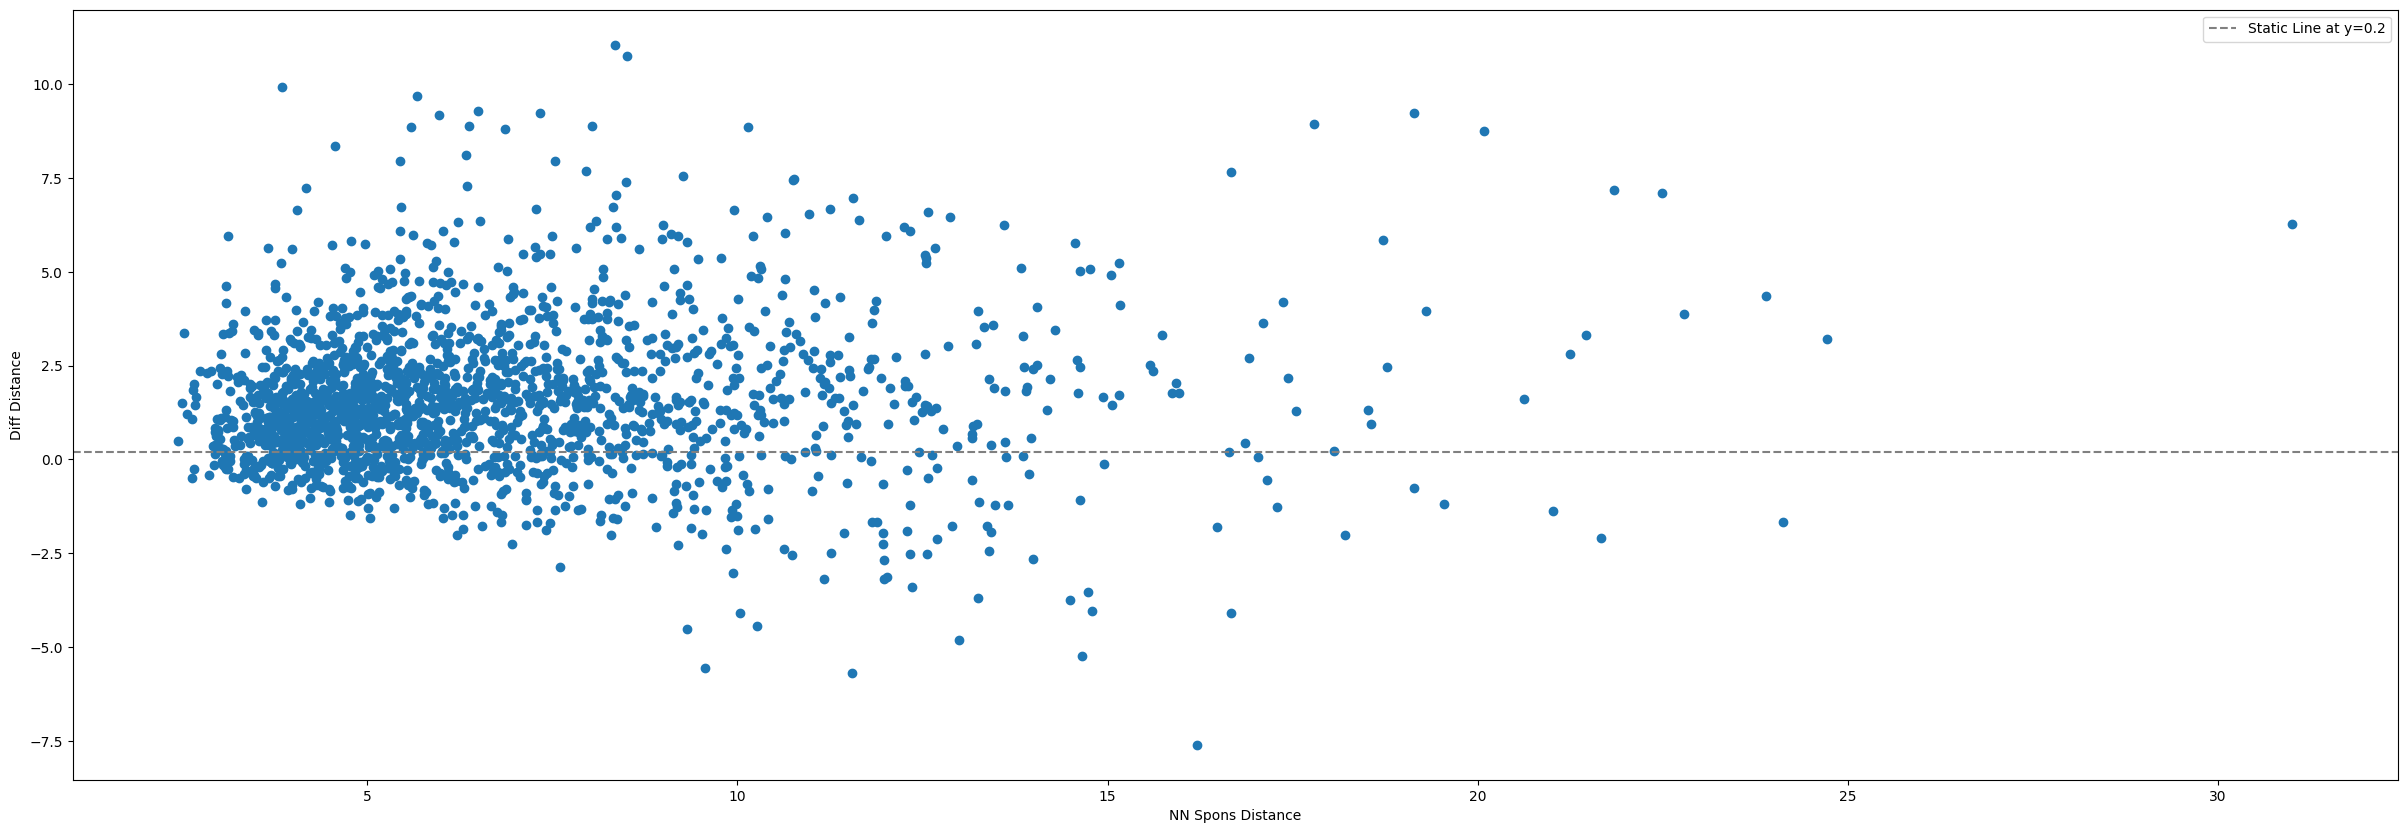

In [62]:
fig, ax = plt.subplots(figsize=(30, 10))
ax.scatter(x=ond_df_predict['NN_Spons_Distance'], y=ond_df_predict['Diff_Distance'])
plt.xlabel('NN Spons Distance')
plt.ylabel('Diff Distance')

ax.axhline(y=0.2, color='grey', linestyle='--', label='Static Line at y=0.2')
plt.legend()
plt.show()

In [40]:
ond_predict_rounded = ond_df_predict[['index','Diff_Distance']]
ond_predict_rounded['DD_Rounded_1'] = round(ond_predict_rounded['Diff_Distance'], 1)
ond_predict_rounded['DD_Rounded_2'] = round(ond_predict_rounded['Diff_Distance'], 2)
ond_predict_rounded['DD_Rounded'] = ond_predict_rounded['Diff_Distance'].apply(lambda x: round(x*2) / 2)
ond_predict_rounded.head(3)

C:\Users\79217\AppData\Local\Temp\ipykernel_33596\3202169443.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ond_predict_rounded['DD_Rounded_1'] = round(ond_predict_rounded['Diff_Distance'], 1)
C:\Users\79217\AppData\Local\Temp\ipykernel_33596\3202169443.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ond_predict_rounded['DD_Rounded_2'] = round(ond_predict_rounded['Diff_Distance'], 2)
C:\Users\79217\AppData\Local\Temp\ipykernel_33596\3202169443.py:4: SettingWithCopyWarning: 
A value is trying to be 

,index,Diff_Distance,DD_Rounded_1,DD_Rounded_2,DD_Rounded
0,101,-0.244823,-0.2,-0.24,0.0
1,102,0.082347,0.1,0.08,0.0
2,104,-0.561372,-0.6,-0.56,-0.5


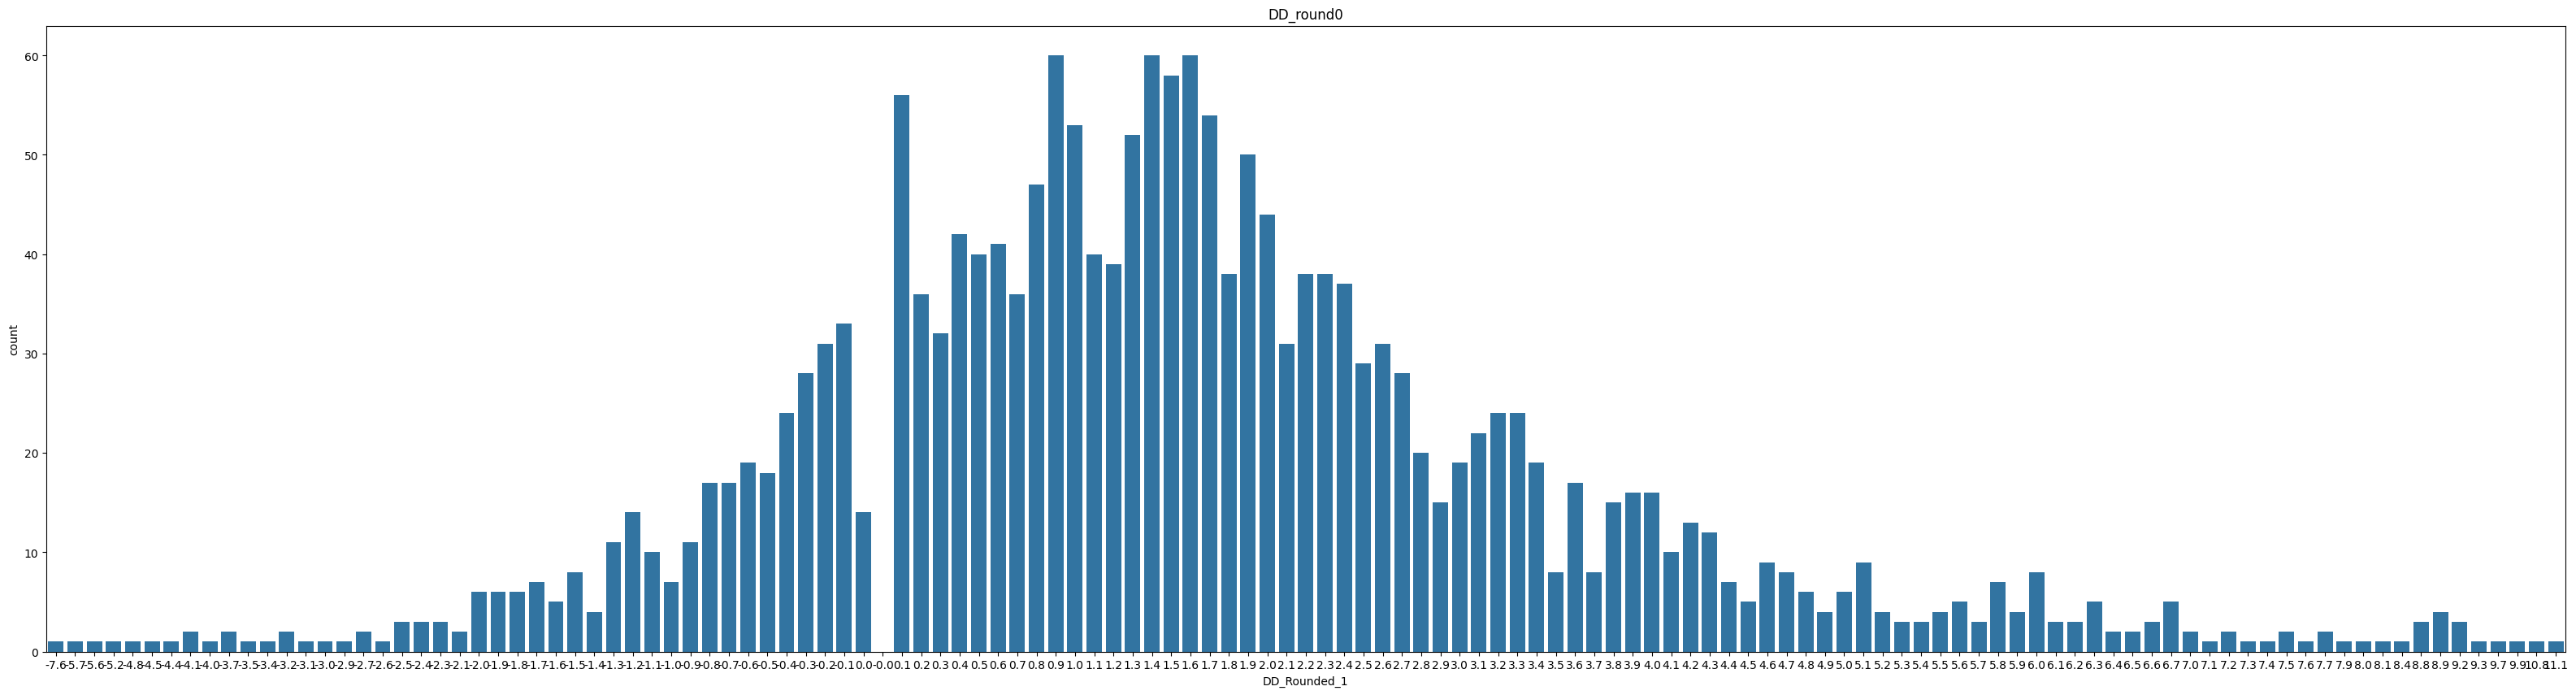

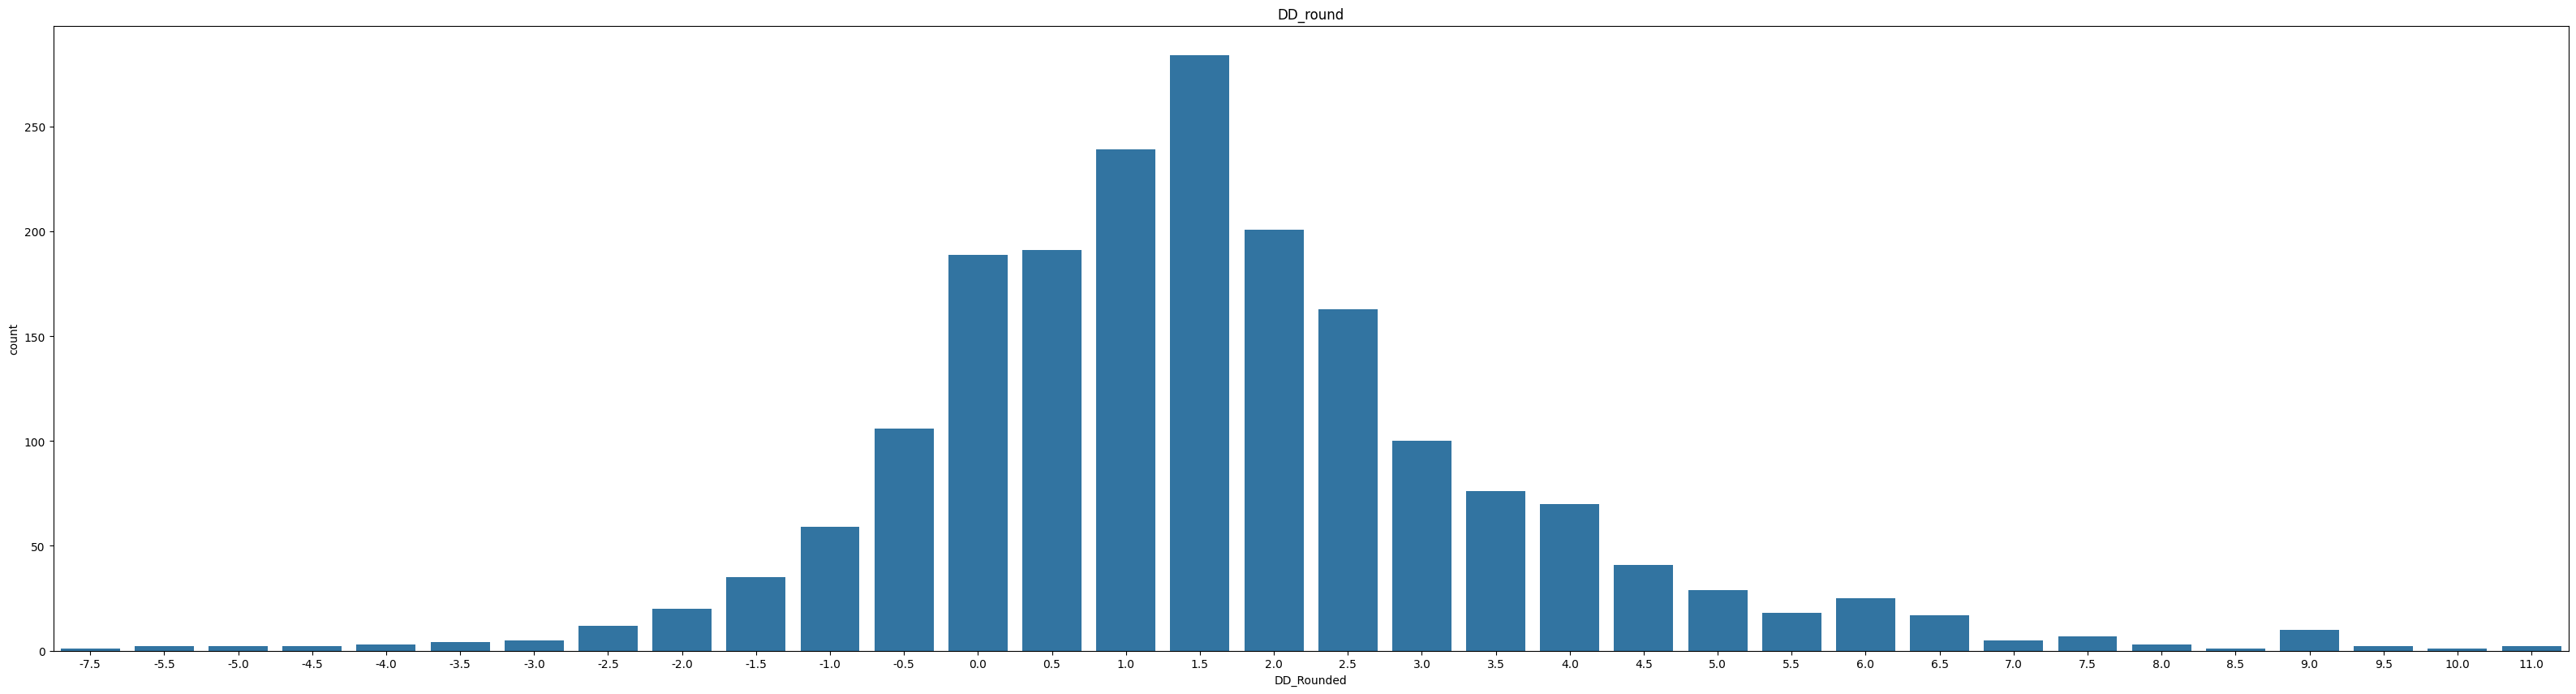

In [41]:
fig, ax = plt.subplots(1, 1, figsize=(40, 10))
sns.countplot(data=ond_predict_rounded, x='DD_Rounded_1', ax=ax)
ax.set_title('DD_round0')
plt.show()

fig, ax = plt.subplots(1, 1, figsize=(40, 10))
sns.countplot(data=ond_predict_rounded, x='DD_Rounded', ax=ax)
ax.set_title('DD_round')
plt.show()

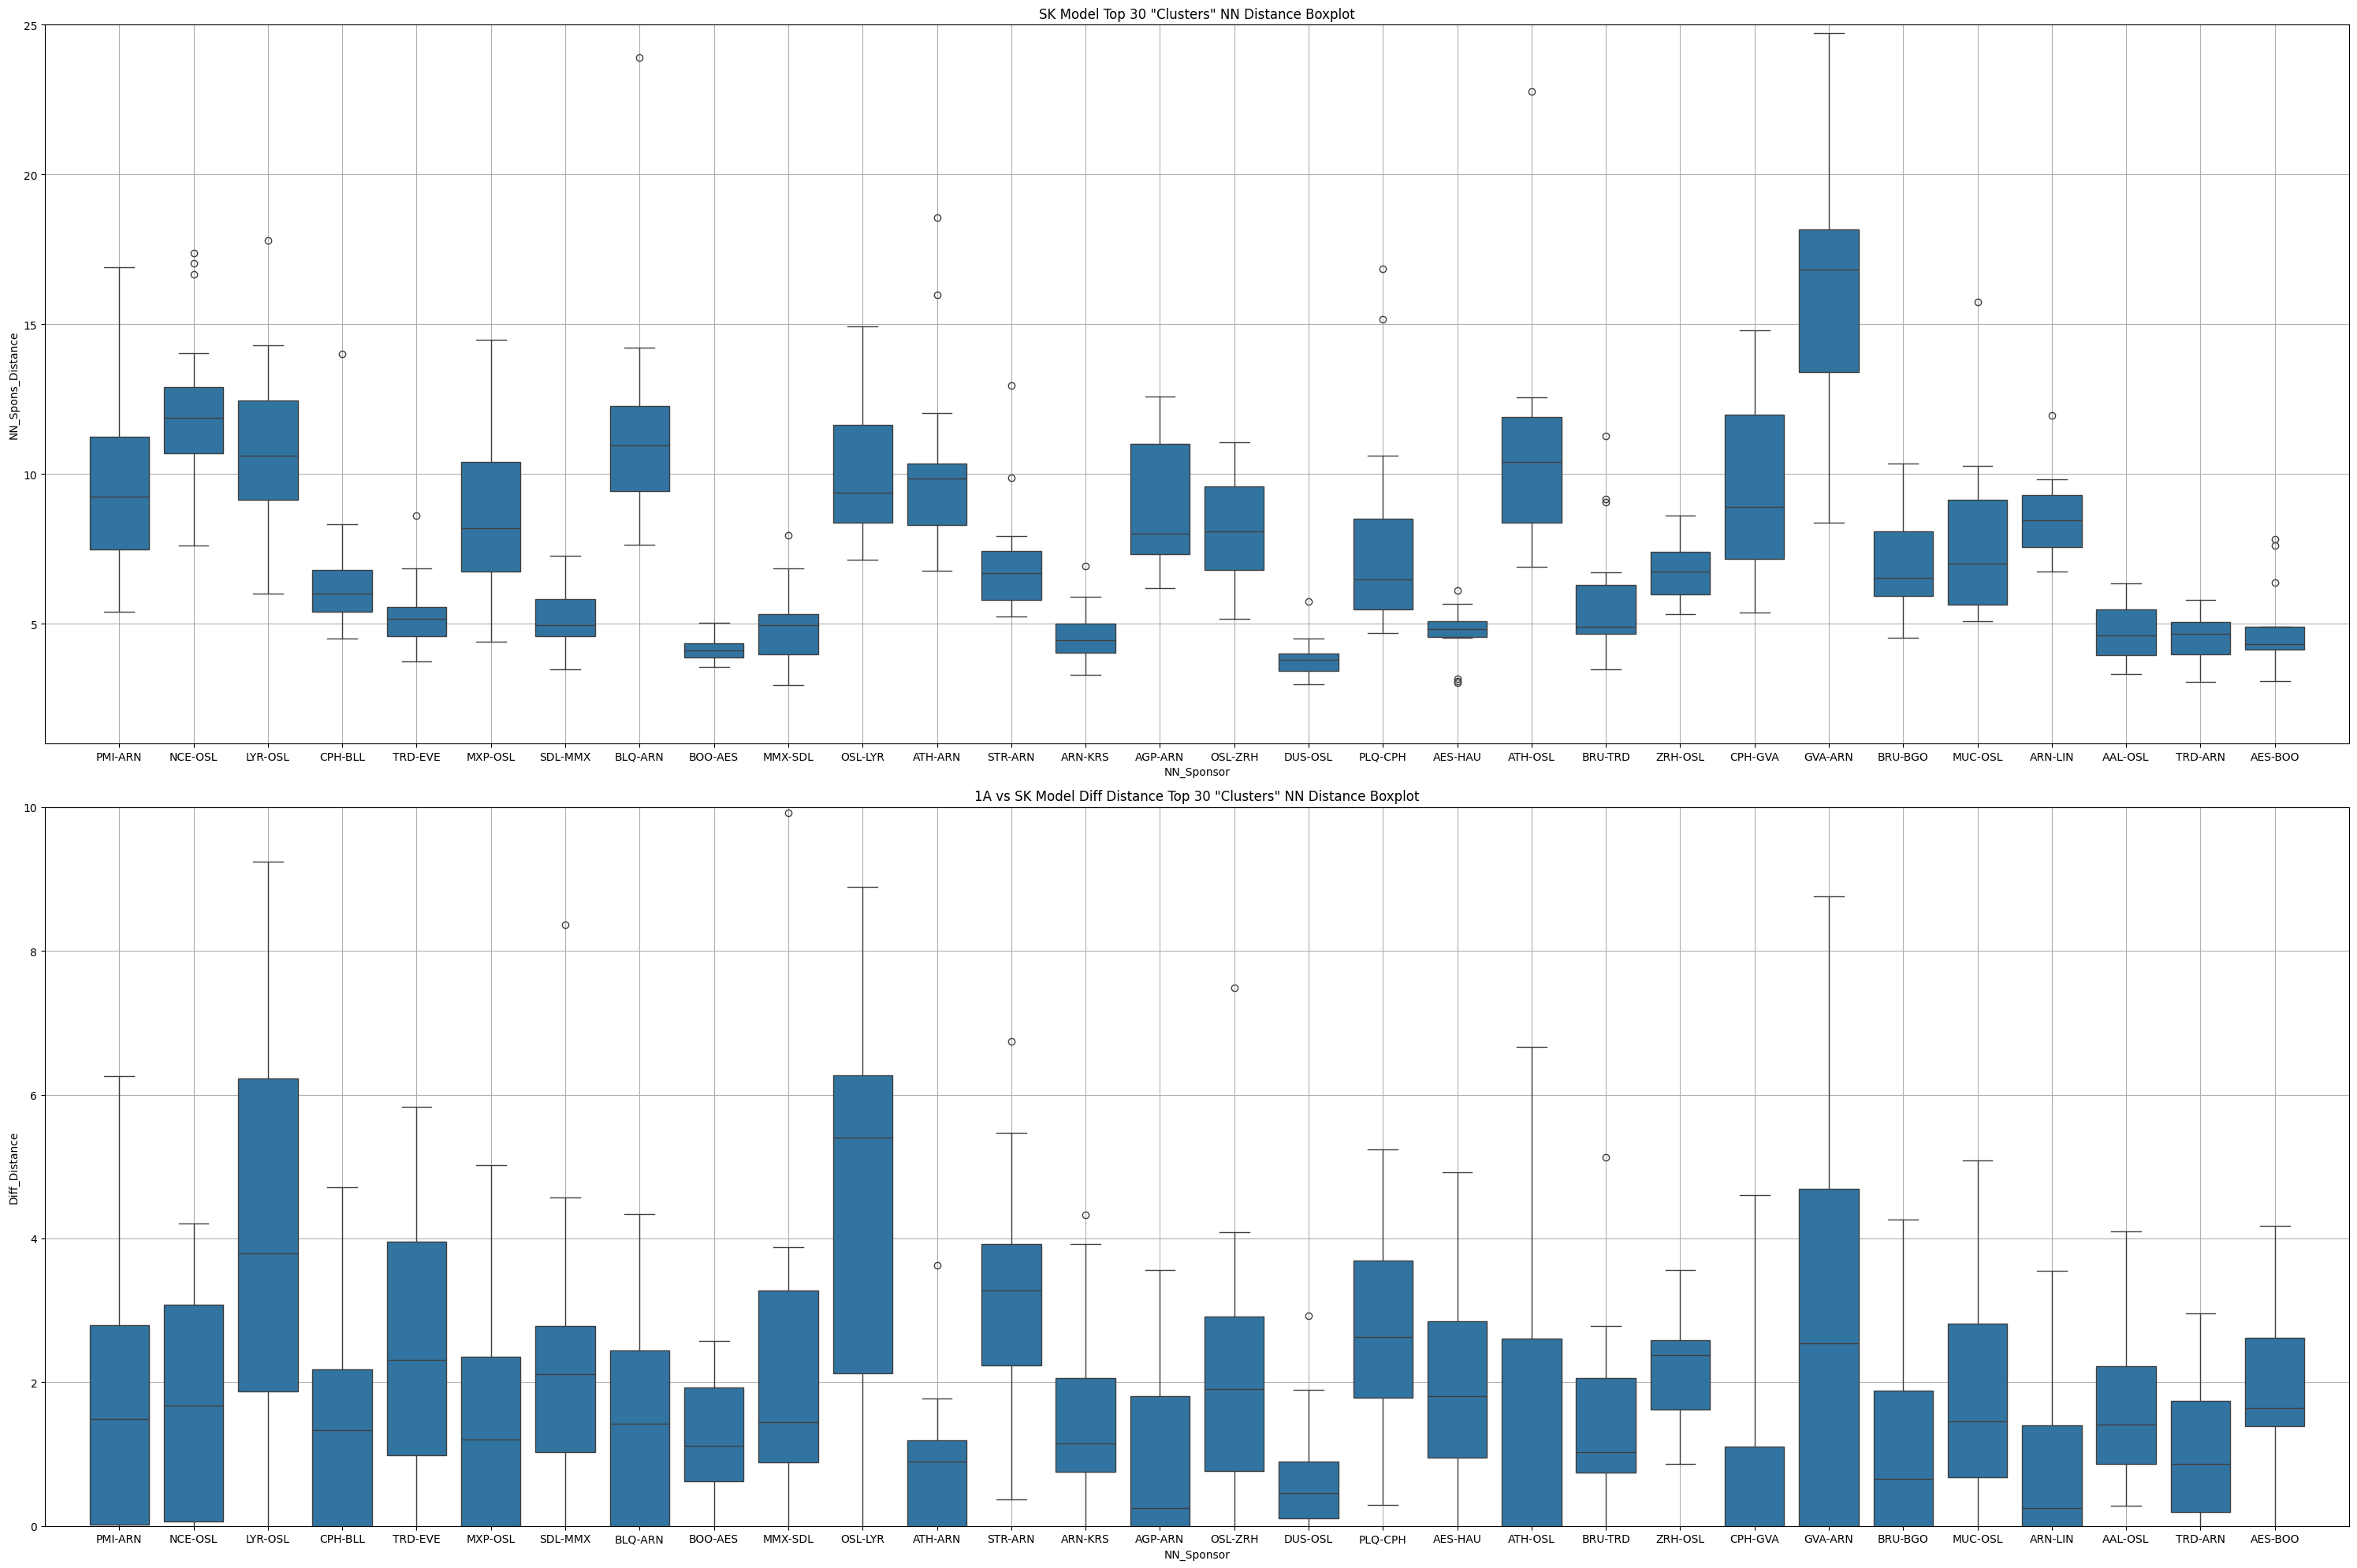

In [42]:
NN_TopCount_Box = NN_sponsor_count_plot.merge(ond_df_predict,left_on = 'NN_Sponsor1', right_on ='NN_Sponsor', how = 'left')
#NN_BottomDist_Box = NN_dist_mean.merge(ond_df_predict,left_on = 'NN_Sponsor2', right_on ='NN_Sponsor', how = 'left')

fig, ax = plt.subplots(2, 1, figsize=(30, 20))

sns.boxplot(data=NN_TopCount_Box, x="NN_Sponsor", y="NN_Spons_Distance", ax=ax[0])
ax[0].set(ylim=(1,25))
ax[0].set(xlim=(0-1, 30))
ax[0].grid()
ax[0].set_title('SK Model Top 30 "Clusters" NN Distance Boxplot')


sns.boxplot(data=NN_TopCount_Box, x="NN_Sponsor", y="Diff_Distance", ax=ax[1])
ax[1].set(ylim=(0,10))
ax[1].set(xlim=(0-1, 30))
ax[1].grid()
ax[1].set_title('1A vs SK Model Diff Distance Top 30 "Clusters" NN Distance Boxplot')

plt.tight_layout()
plt.show()

In [43]:
#COMPARE WITH AMADEUS MODEL

In [56]:
ond1 = 'GVA-OSD'
OnD1 = ond_puc_df[ond_puc_df['ond_key'].str.strip() == ond1].index[0]
NN = ond_puc_df[ond_puc_df['ond_key'].str.strip() == ond_df_predict['NN_Sponsor'][ond_df_predict['ond_key'] == ond1].values[0]].index[0]
AMA = ond_puc_df[ond_puc_df['ond_key'].str.strip() == ond_df_predict['AlteaOnDSponsor'][ond_df_predict['ond_key'] == ond1].values[0]].index[0]


132
10399
4894


In [44]:
ond = 'GVA-OSD'
OnD = ond_puc_df[ond_puc_df['ond_key'].str.strip() == ond].index[0]
Neighbor = ond_puc_df[ond_puc_df['ond_key'].str.strip() == ond_df_predict['NN_Sponsor'][ond_df_predict['ond_key'] == ond].values[0]].index[0]
Altea = ond_puc_df[ond_puc_df['ond_key'].str.strip() == ond_df_predict['AlteaOnDSponsor'][ond_df_predict['ond_key'] == ond].values[0]].index[0]
print(OnD)
print(Neighbor)
print(Altea)

In [58]:
pax_ond_df2 = ond_puc_df[['jan_paxratio', 'feb_paxratio', 'mar_paxratio', 'apr_paxratio', 'may_paxratio', 'jun_paxratio', 'jul_paxratio', 'aug_paxratio', 'sep_paxratio', 'oct_paxratio', 'nov_paxratio', 'dec_paxratio']].iloc[OnD1]
pax_spons_df2 = ond_puc_df[['jan_paxratio', 'feb_paxratio', 'mar_paxratio', 'apr_paxratio', 'may_paxratio', 'jun_paxratio', 'jul_paxratio', 'aug_paxratio', 'sep_paxratio', 'oct_paxratio', 'nov_paxratio', 'dec_paxratio']].iloc[NN]
pax_alt_spons_df2 = ond_puc_df[['jan_paxratio', 'feb_paxratio', 'mar_paxratio', 'apr_paxratio', 'may_paxratio', 'jun_paxratio', 'jul_paxratio', 'aug_paxratio', 'sep_paxratio', 'oct_paxratio', 'nov_paxratio', 'dec_paxratio']].iloc[AMA]
print(pax_ond_df2)

jan_paxratio    0.090816
feb_paxratio    0.200000
mar_paxratio    0.269388
apr_paxratio    0.068367
may_paxratio    0.021429
jun_paxratio    0.039796
jul_paxratio    0.088776
aug_paxratio    0.052041
sep_paxratio    0.032653
oct_paxratio    0.025510
nov_paxratio    0.016327
dec_paxratio    0.094898
Name: 132, dtype: float64


In [ ]:
ond_list = 

In [45]:
pax_ond_df = ond_puc_df[['jan_paxratio','feb_paxratio','mar_paxratio','apr_paxratio','may_paxratio','jun_paxratio','jul_paxratio','aug_paxratio','sep_paxratio','oct_paxratio','nov_paxratio','dec_paxratio']].iloc[OnD]
pax_spons_df = ond_puc_df[['jan_paxratio','feb_paxratio','mar_paxratio','apr_paxratio','may_paxratio','jun_paxratio','jul_paxratio','aug_paxratio','sep_paxratio','oct_paxratio','nov_paxratio','dec_paxratio']].iloc[Neighbor]
pax_alt_spons_df = ond_puc_df[['jan_paxratio','feb_paxratio','mar_paxratio','apr_paxratio','may_paxratio','jun_paxratio','jul_paxratio','aug_paxratio','sep_paxratio','oct_paxratio','nov_paxratio','dec_paxratio']].iloc[Altea]
bkg_ond_df = ond_puc_df[['Bkg_Dbd10%','Bkg_Dbd20%','Bkg_Dbd30%','Bkg_Dbd40%','Bkg_Dbd50%','Bkg_Dbd60%','Bkg_Dbd70%','Bkg_Dbd80%','Bkg_Dbd90%']].iloc[OnD]
bkg_spons_df = ond_puc_df[['Bkg_Dbd10%','Bkg_Dbd20%','Bkg_Dbd30%','Bkg_Dbd40%','Bkg_Dbd50%','Bkg_Dbd60%','Bkg_Dbd70%','Bkg_Dbd80%','Bkg_Dbd90%']].iloc[Neighbor]
bkg_alt_spons_df = ond_puc_df[['Bkg_Dbd10%','Bkg_Dbd20%','Bkg_Dbd30%','Bkg_Dbd40%','Bkg_Dbd50%','Bkg_Dbd60%','Bkg_Dbd70%','Bkg_Dbd80%','Bkg_Dbd90%']].iloc[Altea]
dow_ond_df = ond_puc_df[['dow1_ratio','dow2_ratio','dow3_ratio','dow4_ratio','dow5_ratio','dow6_ratio','dow7_ratio']].iloc[OnD]
dow_spons_df = ond_puc_df[['dow1_ratio','dow2_ratio','dow3_ratio','dow4_ratio','dow5_ratio','dow6_ratio','dow7_ratio']].iloc[Neighbor]
dow_alt_spons_df = ond_puc_df[['dow1_ratio','dow2_ratio','dow3_ratio','dow4_ratio','dow5_ratio','dow6_ratio','dow7_ratio']].iloc[Altea]
c_ond_df = ond_puc_df[['CMP_ratio','Ave_Rev','ond_key','C_ratio']].iloc[OnD]
c_spons_df = ond_puc_df[['CMP_ratio','Ave_Rev','ond_key','C_ratio']].iloc[Neighbor]
c_alt_spons_df = ond_puc_df[['CMP_ratio','Ave_Rev','ond_key','C_ratio']].iloc[Altea]

In [47]:
pax_x = range(1,13,1)
pax_ond_y = pax_ond_df.to_numpy().tolist()
pax_spons_y = pax_spons_df.to_numpy().tolist()
pax_alt_spons_y = pax_alt_spons_df.to_numpy().tolist()
bkg_x = range(90,0,-10)
bkg_ond_y = bkg_ond_df.to_numpy().tolist()
bkg_spons_y = bkg_spons_df.to_numpy().tolist()
bkg_alt_spons_y = bkg_alt_spons_df.to_numpy().tolist()
dow_x = range(1,8)
dow_ond_y = dow_ond_df.to_numpy().tolist()
dow_spons_y = dow_spons_df.to_numpy().tolist()
dow_alt_spons_y = dow_alt_spons_df.to_numpy().tolist()

c_x = range(1,4)
c_ond_y = c_ond_df.to_numpy().tolist()
c_spons_y = c_spons_df.to_numpy().tolist()
c_alt_spons_y = c_alt_spons_df.to_numpy().tolist()

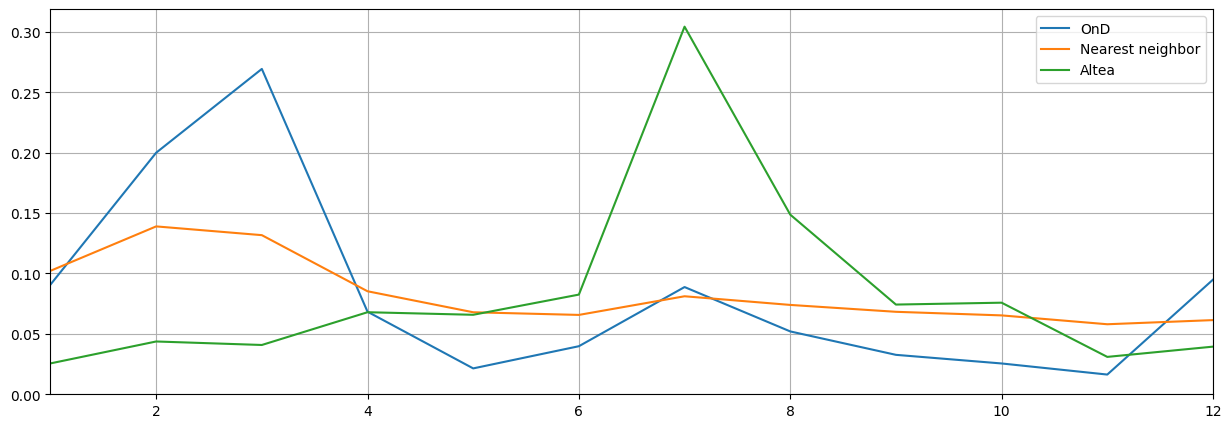

None

In [60]:
pax_x2 = range(1,13,1)
pax_ond_y2 = pax_ond_df2.to_numpy().tolist()
pax_spons_y2 = pax_spons_df2.to_numpy().tolist()
pax_alt_spons_y2 = pax_alt_spons_df2.to_numpy().tolist()
fig, axes = plt.subplots(1, 1, figsize=(15,5))
p = sns.lineplot(x=pax_x2, y=pax_ond_y2, label = 'OnD')
p = sns.lineplot(x=pax_x2, y=pax_spons_y2, label = 'Nearest neighbor')
p = sns.lineplot(x=pax_x2, y=pax_alt_spons_y2, label = 'Altea')
p.set(ylim=(0,None))
p.set(xlim=(1,12))
plt.grid()
display(plt.show())

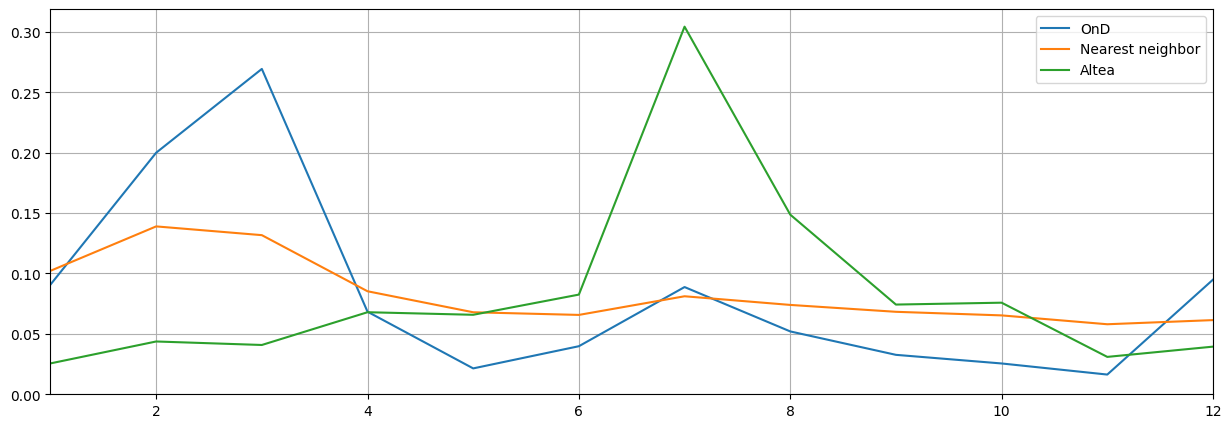

None

In [48]:
fig, axes = plt.subplots(1, 1, figsize=(15,5))
p = sns.lineplot(x=pax_x, y=pax_ond_y, label = 'OnD')
p = sns.lineplot(x=pax_x, y=pax_spons_y, label = 'Nearest neighbor')
p = sns.lineplot(x=pax_x, y=pax_alt_spons_y, label = 'Altea')
p.set(ylim=(0,None))
p.set(xlim=(1,12))
plt.grid()
display(plt.show())

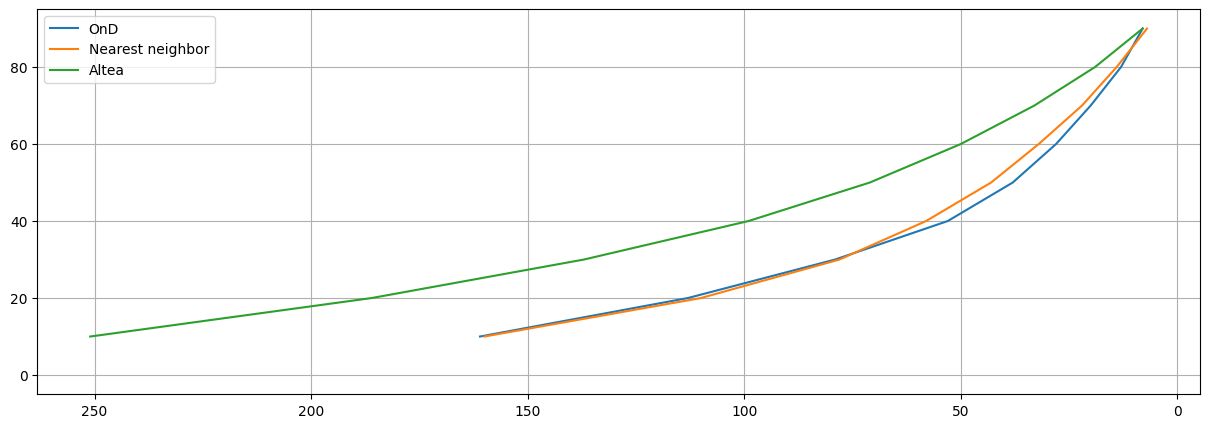

None

In [49]:
fig, axes = plt.subplots(1, 1, figsize=(15,5))
p = sns.lineplot(y=bkg_x, x=bkg_ond_y, label = 'OnD')
p = sns.lineplot(y=bkg_x, x=bkg_spons_y, label = 'Nearest neighbor')
p = sns.lineplot(y=bkg_x, x=bkg_alt_spons_y, label = 'Altea')
p.invert_xaxis()
p.set(ylim=(-5,95))
plt.grid()
display(plt.show())

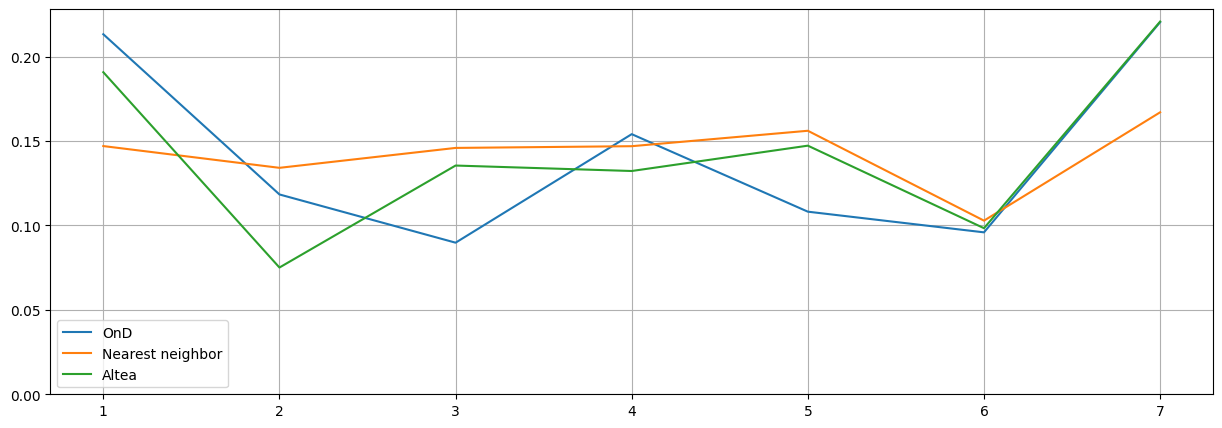

None

In [50]:
fig, axes = plt.subplots(1, 1, figsize=(15,5))
p = sns.lineplot(x=dow_x, y=dow_ond_y, label = 'OnD')
p = sns.lineplot(x=dow_x, y=dow_spons_y, label = 'Nearest neighbor')
p = sns.lineplot(x=dow_x, y=dow_alt_spons_y, label = 'Altea')
p.set(ylim=(0,None))
plt.grid()
display(plt.show())

C:\Users\79217\AppData\Local\Temp\ipykernel_33596\248570031.py:2: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(x="ond", y="c_ratio", data=barplot_df, ci=None)


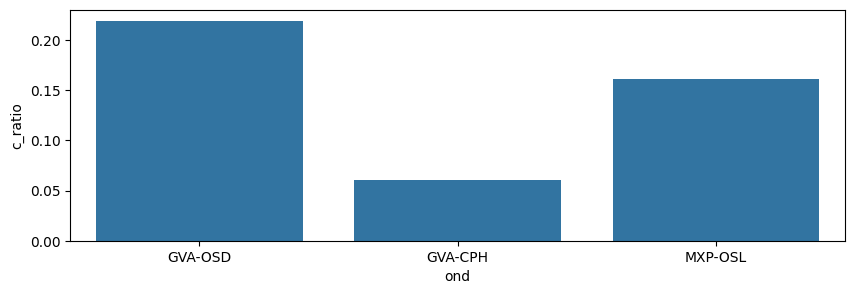

None

C:\Users\79217\AppData\Local\Temp\ipykernel_33596\248570031.py:6: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(x="ond", y="cmp_ratio", data=barplot_df, ci=None)


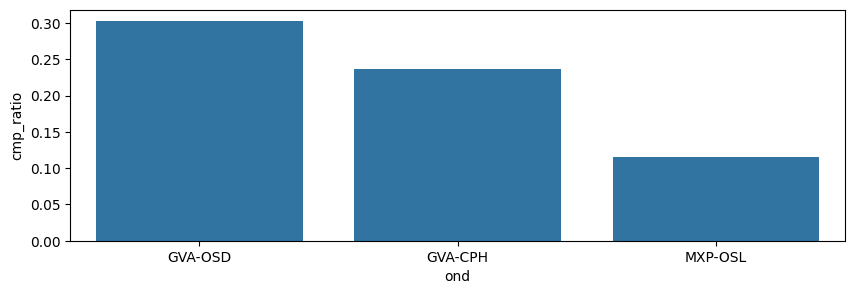

None

C:\Users\79217\AppData\Local\Temp\ipykernel_33596\248570031.py:10: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(x="ond", y="ave_rev", data=barplot_df, ci=None)


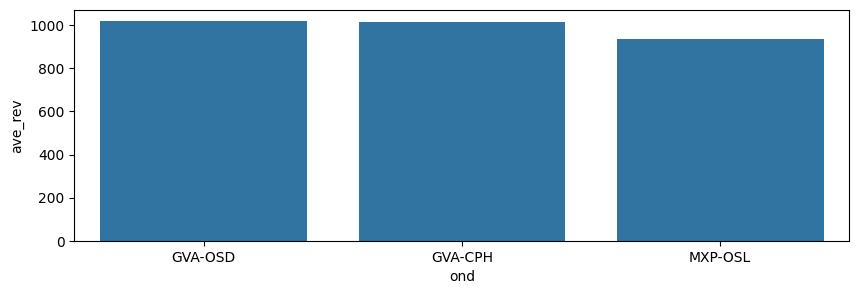

None

In [51]:
fig, axes = plt.subplots(1, 1, figsize=(10,3))
sns.barplot(x="ond", y="c_ratio", data=barplot_df, ci=None)
display(plt.show())

fig, axes = plt.subplots(1, 1, figsize=(10,3))
sns.barplot(x="ond", y="cmp_ratio", data=barplot_df, ci=None)
display(plt.show())

fig, axes = plt.subplots(1, 1, figsize=(10,3))
sns.barplot(x="ond", y="ave_rev", data=barplot_df, ci=None)
display(plt.show())